In [1]:
import numpy as np
import os
import cPickle
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../simulation')
import sim_functions as sim
from scipy.optimize import curve_fit


In [2]:
data_dir='../../data/radio/sim/'
mag=2.03
average_density = 6.5e-4 # in kg/m^3


In [31]:
def read_file(filename):
    
    infile=open(filename,'r')
    info=cPickle.load(infile)
    infile.close()
    
    
    em_energy=info['em_energy']
    energy=info['energy']
    zenith=info['zenith']
    azimuth=info['azimuth']
    xmax=info['xmax']
    alpha=info['alpha']
    Erad=info['Erad']
    Erad_ce=info['Erad_ce']
    Erad_gm=info['Erad_gm']
    density=info['density']
    density2=info['density2']
    event=info['event']

    
    Erad=Erad+Erad*.11-Erad*0.0336
    Erad_ce=Erad_ce+Erad_ce*.11-Erad_ce*0.0336
    Erad_gm=Erad_gm+Erad_gm*.11-Erad_gm*0.0336

    return em_energy,energy,zenith,azimuth,xmax,alpha,Erad,Erad_gm,Erad_ce,density,density2,event



In [32]:
em_energy_P,energy_P,zenith_P,azimuth_P,xmax_P,alpha_P,Erad_P,Erad_gm_P,Erad_ce_P,density_P,density2_P,event_P=read_file(data_dir+'compiled_sims_proton_debug2.dat')
em_energy_Fe,energy_Fe,zenith_Fe,azimuth_Fe,xmax_Fe,alpha_Fe,Erad_Fe,Erad_gm_Fe,Erad_ce_Fe,density_Fe,density2_Fe,event_Fe=read_file(data_dir+'compiled_sims_iron_debug2.dat')


In [33]:
# fit function for a parameterization
rho_avg=np.average(np.concatenate([density_P*1e3*np.cos(zenith_P),density_Fe*1e3*np.cos(zenith_Fe)]))
print rho_avg
def a_function(x,p0,p1,p2):
    return p2+p0*np.exp(p1*(x-rho_avg))

0.7233955406207339


In [34]:
y_plt_P=np.sin(alpha_P)*np.sqrt(Erad_ce_P/Erad_gm_P)#*mag**0.9
x_plt_P=density_P*1e3*np.cos(zenith_P)
y_plt_Fe=np.sin(alpha_Fe)*np.sqrt(Erad_ce_Fe/Erad_gm_Fe)#*mag**0.9
x_plt_Fe=density_Fe*1e3*np.cos(zenith_Fe)

xdata=np.concatenate([x_plt_P,x_plt_Fe])
ydata=np.concatenate([y_plt_P,y_plt_Fe])

popt, pcov = curve_fit(a_function, xdata, ydata,p0=[0.43,1.11,-0.24], bounds=([0.3,0.8,-0.3], [0.6, 1.5,-0.1]))
p0=popt[0]
p1=popt[1]
p2=popt[2]
print popt


[ 0.3         0.86975066 -0.18042037]


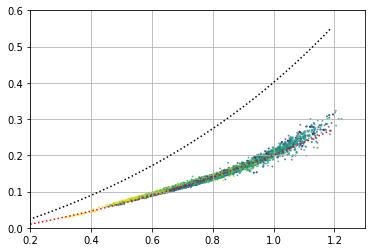

In [35]:


# fit from PRL
x_test=np.arange(0,1.2,0.01)
y_test=0.43*(np.exp(1.11*(x_test-0.64)))-.24

y_fit=a_function(x_test,popt[0],popt[1],popt[2])


fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

sc = ax1.scatter(x_plt_P,y_plt_P, alpha=0.6,s=1,c=np.sin(alpha_P))#vmin=np.radians(0),vmax=np.radians(60),c=zenith_P) 
#sc = ax1.scatter(x_plt_Fe,y_plt_Fe, alpha=0.6,s=1,vmin=np.radians(0),vmax=np.radians(60),c=zenith_Fe) 
ax1.plot(x_test,y_test,':',color='black')
ax1.plot(x_test,y_fit,':',color='red')

ax1.set_xlim([0.2,1.3])

ax1.set_ylim([0.0,.6])

ax1.grid()


plt.show()
plt.close()




In [36]:
def return_a(rho,avg,p0,p1,p2):
    a=np.zeros(len(rho))
    for i in np.arange(len(rho)):
        a[i]= p2+p0*np.exp(p1*(rho[i]-avg))
    return a

In [37]:
a_P=return_a(density_P*1e3*np.cos(zenith_P),rho_avg,p0,p1,p2)/mag**0.9
a_Fe=return_a(density_Fe*1e3*np.cos(zenith_Fe),rho_avg,p0,p1,p2)/mag**0.9



In [38]:
Srd_P=Erad_P/np.sin(alpha_P)**2/mag**1.8
Srd_Fe=Erad_Fe/np.sin(alpha_Fe)**2/mag**1.8

Srd_P_1=Erad_P/(a_P**2+(1-a_P**2)*np.sin(alpha_P)**2)/mag**1.8
Srd_Fe_1=Erad_Fe/(a_Fe**2+(1-a_Fe**2)*np.sin(alpha_Fe)**2)/mag**1.8


In [39]:
a_em_p,b_em_p,a_sig_em_p,b_sig_em_p=sim.getFit(em_energy_P,Srd_P_1)
a_em_fe,b_em_fe,a_sig_em_fe,b_sig_em_fe=sim.getFit(em_energy_Fe,Srd_Fe_1)

print a_em_p,b_em_p
print a_em_fe,b_em_fe

EM_sr_P=1e18*np.power((Srd_P_1/(a_em_p*1e7)),(1/b_em_p))
EM_sr_Fe=1e18*np.power((Srd_Fe_1/(a_em_fe*1e7)),(1/b_em_fe))

1.6964200583277453 1.9985588441931457
1.7595352184545499 2.0050716086624556


In [40]:
def e_function(x,p0,p1,p2):
    return p2+p0*np.exp(p1*(x-rho_avg))

In [41]:
x_plt_P=density_P*1e3*np.cos(zenith_P)
y_plt_P=EM_sr_P/em_energy_P
x_plt_Fe=density_Fe*1e3*np.cos(zenith_Fe)
y_plt_Fe=EM_sr_Fe/em_energy_Fe

xdata=np.concatenate([x_plt_P,x_plt_Fe])
ydata=np.concatenate([y_plt_P,y_plt_Fe])

popt, pcov = curve_fit(a_function, xdata, ydata,p0=[0.25,-3.08,0.77], bounds=([0.1,-5.0,0.2], [0.6, 0.0,1.2]))
print popt
p0e=popt[0]
p1e=popt[1]
p2e=popt[2]

[ 0.6        -0.67570502  0.4001336 ]


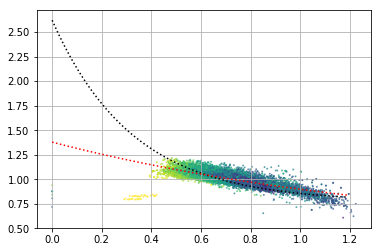

In [42]:
x_test=np.arange(0,1.2,0.01)
y_test=0.25*(np.exp(-3.08*(x_test-0.65)))+0.77
y_fit=p0e*(np.exp(p1e*(x_test-rho_avg)))+p2e




fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

sc1 = ax1.scatter(x_plt_P,y_plt_P, alpha=0.6,s=1,vmin=np.radians(0),vmax=np.radians(60),c=zenith_P) 
sc2 = ax1.scatter(x_plt_Fe,y_plt_Fe, alpha=0.6,s=1,vmin=np.radians(0),vmax=np.radians(60),c=zenith_Fe) 
ax1.plot(x_test,y_test,':',color='black')
ax1.plot(x_test,y_fit,':',color='red')
#ax1.set_xlim([0.2,1.3])

#ax1.set_ylim([0.6,1.25])

ax1.grid()
#plt.colorbar(sc1)

plt.show()
plt.close()


In [43]:
Srd_P_2=Erad_P/(a_P**2+(1-a_P**2)*np.sin(alpha_P)**2)/(1-p0e+p0e*np.exp(p1e*(density_P*1e3*np.cos(zenith_P)-rho_avg)))**2/mag**1.8
Srd_Fe_2=Erad_Fe/(a_Fe**2+(1-a_Fe**2)*np.sin(alpha_Fe)**2)/(1-p0e+p0e*np.exp(p1e*(density_Fe*1e3*np.cos(zenith_Fe)-rho_avg)))**2/mag**1.8


In [44]:
a_em_p,b_em_p,a_sig_em_p,b_sig_em_p=sim.getFit(em_energy_P,Srd_P_2)
a_em_fe,b_em_fe,a_sig_em_fe,b_sig_em_fe=sim.getFit(em_energy_Fe,Srd_Fe_2)

a_tot_p,b_tot_p,a_sig_tot_p,b_sig_tot_p=sim.getFit(energy_P,Srd_P_2)
a_tot_fe,b_tot_fe,a_sig_tot_fe,b_sig_tot_fe=sim.getFit(energy_Fe,Srd_Fe_2)

print '\n\nEM energy fit'
print '___________________'
print '{0:.3f} +/- {1:.3f}       {2:.3f} +/- {3:.3f}'.format(a_em_p,a_sig_em_p,b_em_p,b_sig_em_p)
print '{0:.3f} +/- {1:.3f}       {2:.3f} +/- {3:.3f}'.format(a_em_fe,a_sig_em_fe,b_em_fe,b_sig_em_fe)


print '\n\nTotal energy fit'
print '___________________'
print '{0:.3f} +/- {1:.3f}       {2:.3f} +/- {3:.3f}'.format(a_tot_p,a_sig_tot_p,b_tot_p,b_sig_tot_p)
print '{0:.3f} +/- {1:.3f}       {2:.3f} +/- {3:.3f}'.format(a_tot_fe,a_sig_tot_fe,b_tot_fe,b_sig_tot_fe)





EM energy fit
___________________
1.745 +/- 0.004       1.997 +/- 0.001
1.729 +/- 0.003       2.013 +/- 0.001


Total energy fit
___________________
1.352 +/- 0.004       2.025 +/- 0.002
1.171 +/- 0.002       2.071 +/- 0.001


In [45]:
x = np.linspace(10**16,10**18.5,100)
x_data = np.linspace(10**17,10**18,100)

#EM_sr_P=1e18*np.power((Srd_P_2/(a_em_p*1e7)),(1/b_em_p))
#EM_sr_Fe=1e18*np.power((Srd_P_2/(a_em_fe*1e7)),(1/b_em_fe))

rad_em_fit_p=sim.energy_to_rad(x,a_em_p,b_em_p)
rad_em_fit_fe=sim.energy_to_rad(x,a_em_fe,b_em_fe)

rad_tot_fit_p=sim.energy_to_rad(x,a_tot_p,b_tot_p)
rad_tot_fit_fe=sim.energy_to_rad(x,a_tot_fe,b_tot_fe)

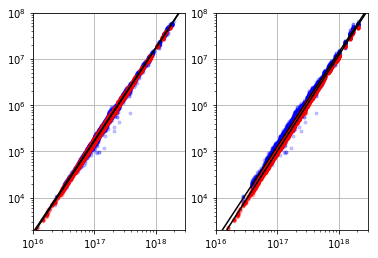

In [46]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

#ax1.plot(em_energy_P,Srd_P,'.',color='black',alpha=0.2)
#ax1.plot(em_energy_P,Srd_P_1,'.',color='red',alpha=0.2)

ax1.plot(em_energy_P,Srd_P_2,'.',color='blue',alpha=0.2)
ax1.plot(em_energy_Fe,Srd_Fe_2,'.',color='red',alpha=0.2)

ax2.plot(energy_P,Srd_P_2,'.',color='blue',alpha=0.2)
ax2.plot(energy_Fe,Srd_Fe_2,'.',color='red',alpha=0.2)

#sc1 = ax1.scatter(em_energy_P,Srd_P_2, alpha=0.6,s=1,vmin=np.radians(0),vmax=np.radians(60),c=alpha_P) #vmin=np.radians(0),vmax=np.radians(60)
#sc2 = ax1.scatter(em_energy_Fe,Srd_Fe_2, alpha=0.6,s=1,vmin=np.radians(0),vmax=np.radians(60),c=alpha_Fe) #vmin=np.radians(0),vmax=np.radians(60)

#sc3 = ax2.scatter(energy_P,Srd_P_2, alpha=0.6,s=1,vmin=np.radians(0),vmax=np.radians(60),c=alpha_P) #vmin=np.radians(0),vmax=np.radians(60)
#sc4 = ax2.scatter(energy_Fe,Srd_Fe_2, alpha=0.6,s=1,vmin=np.radians(0),vmax=np.radians(60),c=alpha_Fe) #vmin=np.radians(0),vmax=np.radians(60)


#ax1.plot(em_energy_Fe,Srd_Fe_2,'.',color='red',alpha=0.2)
#ax1.scatter(em_energy_P,Srd_P_2) #vmin=np.radians(0),vmax=np.radians(60)

ax1.plot(x,rad_em_fit_p,color='black')
ax1.plot(x,rad_em_fit_fe,color='black')

ax2.plot(x,rad_tot_fit_p,color='black')
ax2.plot(x,rad_tot_fit_fe,color='black')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.axis([1e16,3e18,2e3,1e8])
ax1.grid()

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.axis([1e16,3e18,2e3,1e8])
ax2.grid()

plt.show()
plt.close()